# SVI with Gaussian posterior

In this notebook, we implement stochastic Variational Inference in pytorch. <br/>
The forms of `prior` and `approximate posterior` are assumed to be `Gaussian` 
with predefined means and standard deviation. <br />
The standard deviation of likelihood is predifined, 
however likelihood `mean` is computed using an observed toy dataset. 

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
softplus = torch.nn.Softplus()
softmax = torch.nn.Softmax(dim=0)
num_samples = [100, 100]  # Number of samples
num_components = 1
num_steps = 3000

## Generating Data
We generate a unimodal dataset.

In [3]:
def create_unimodal_data(num_samples, w, scale, low=-10, high=10):
    x = np.random.uniform(low=low, high=high, size=(num_samples, 1))
    t = w * x + np.random.normal(size=(num_samples, 1), scale=scale)
    x = torch.tensor(x)
    t = torch.tensor(t)
    return x, t

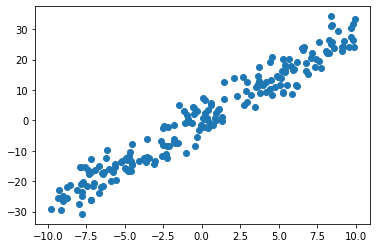

In [4]:
x, t = create_unimodal_data(200, 2.8, 4., low=-10, high=10)
plt.scatter(x, t)

## Sampling
`gaussian_sample` function samples from a gaussian with reparameterization.<br />


In [5]:
def gaussian_sample(mean, std, num_samples, D=1):
    eps = torch.randn(size=(num_samples, D))
    z = eps * std + mean
    return z

`log_gmm` and `log_gaussian` compute log pdf of gmm and gaussian ditributions respectively. 

In [6]:
def log_gaussian(x, mean, std):
    return -0.5 * torch.log(2 * np.pi * std ** 2) - (0.5 * (1 / (std ** 2)) * (x - mean) ** 2)

def log_gmm(x, means, stds, log_pais):
    comp_log_dens = torch.stack([log_gaussian(x, mu, std) for (mu, std) in zip(means, stds)]).T
    log_weights = log_normalize(log_pais)
    return torch.logsumexp(comp_log_dens + log_weights, axis=-1, keepdims=False)

def log_normalize(x):
    return x - torch.logsumexp(x, 0)


Lets assume our approximate posterior, `q`,  is a mixture of Gaussians with two components,
our prior is a Gaussian and likelihood is also a mixture of Gaussians.


In [7]:
q_means = torch.nn.Parameter(torch.tensor([2.]), requires_grad=True)
q_stds = torch.nn.Parameter(torch.tensor([.8]), requires_grad=True)
q_log_pais = torch.nn.Parameter(torch.log(torch.tensor([1.])), requires_grad=True)
q_fn = lambda t: log_gmm(t, q_means, softplus(q_stds), q_log_pais)

In [8]:
likelihood_stds = torch.tensor([4.6])
likelihood_log_pais = torch.log(torch.tensor([1.]))
likelihood_fn = lambda t: log_gmm(t, likelihood_means, likelihood_stds)

In [9]:
p_means = torch.tensor([-4.])
p_stds = torch.tensor([1.])
p_log_pais = torch.log(torch.tensor([1.]))
p_fn = lambda t: log_gmm(t, p_means, softplus(p_stds), p_log_pais)

We can plot the true posterior.

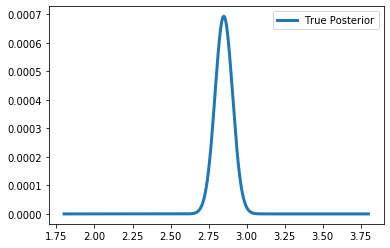

In [10]:
wn = torch.arange(1.8, 3.8, 0.0001)
log_likelihood= torch.sum(log_gmm(t, [wn * x], likelihood_stds, likelihood_log_pais), 1)
log_prior = p_fn(wn)

log_true_posterior = log_likelihood + log_prior
log_true_posterior = log_true_posterior - torch.max(log_true_posterior)
true_posterior = torch.exp(log_true_posterior) / torch.sum(torch.exp(log_true_posterior))

posterior = torch.exp(q_fn(wn))

plt.plot(wn, true_posterior, linewidth=3, label="True Posterior")

plt.legend()
plt.show()

In [11]:
import math
def gaussian(x, mean, std):
    return (1 / torch.sqrt(torch.FloatTensor([2*math.pi])*std**2)) * torch.exp(-((x - mean) ** 2.) / (2 * std**2))

def gmm(x, means, variances, pais):
    return sum([pai * gaussian(x, mu, var) for (pai, mu, var) in zip(pais, means, variances)])

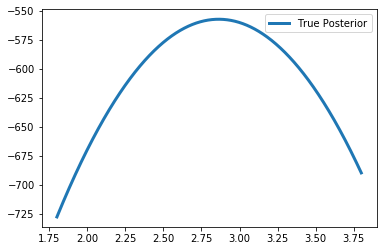

In [12]:
likelihood= torch.sum(gmm(t, [wn * x], likelihood_stds, likelihood_log_pais), 0)
plt.plot(wn, log_likelihood, linewidth=3, label="True Posterior")

plt.legend()
plt.show()

In [13]:
def compute_elbo(x, t):
    elbo = 0
    for c in range(num_components):
        # c = torch.randint(0, 2, [1]) ## we can replace the loop over comps with this line to sample the component
        z = gaussian_sample(q_means[c], softplus(q_stds[c]), num_samples[c])
        
        q_likelihood = torch.mean(q_fn(z))
        prior = torch.mean(p_fn(z))
        log_likelihood = torch.mean(torch.sum(log_gmm(t, [z.T * x], likelihood_stds,
                        likelihood_log_pais), 1))
        elbo_c = q_likelihood - prior - log_likelihood
        elbo += elbo_c * softmax(q_log_pais)[c]
    return elbo

# Optimizer
We define an optimizer, and pass the variables that we intend to optimize. 

In [14]:
optimizer = torch.optim.Adam([
    {'params': [q_log_pais, q_means, q_stds], 'lr': 0.02}])

## Training

In [15]:
for step in range(num_steps):
    loss = compute_elbo(x, t)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    if step % 250 == 0:
        print('Step:{} Loss: {:.6f}, '
              'means:{}, '
              'stds:{}, '
              'pais:{}'
              .format(step, loss.item(), q_means.data.numpy(), 
                      softplus(q_stds).data.numpy(),
                      softmax(q_log_pais).data.numpy())
             )

Step:0 Loss: 846.881336, means:[2.02], stds:[1.1573441], pais:[1.]
Step:250 Loss: 578.956752, means:[2.852712], stds:[0.21906987], pais:[1.]
Step:500 Loss: 575.225605, means:[2.8492684], stds:[0.13007586], pais:[1.]
Step:750 Loss: 574.757223, means:[2.8474677], stds:[0.09767898], pais:[1.]
Step:1000 Loss: 574.291758, means:[2.8447063], stds:[0.08126739], pais:[1.]
Step:1250 Loss: 574.297405, means:[2.85237], stds:[0.07172117], pais:[1.]
Step:1500 Loss: 574.193168, means:[2.8514848], stds:[0.06593373], pais:[1.]
Step:1750 Loss: 574.176452, means:[2.8484871], stds:[0.06235664], pais:[1.]
Step:2000 Loss: 574.194628, means:[2.8477316], stds:[0.06016498], pais:[1.]
Step:2250 Loss: 574.195522, means:[2.8457963], stds:[0.0584971], pais:[1.]
Step:2500 Loss: 574.189978, means:[2.8539217], stds:[0.05791222], pais:[1.]
Step:2750 Loss: 574.181921, means:[2.8495734], stds:[0.05769226], pais:[1.]


## Plotting

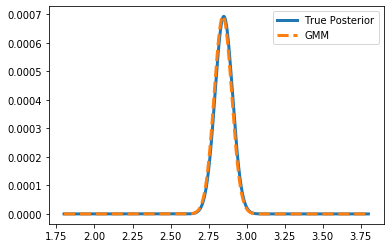

In [16]:
wn = torch.arange(1.8, 3.8 , 0.0001)
log_likelihood = torch.sum(log_gmm(t, [wn * x],
                                   likelihood_stds, likelihood_log_pais), 1)
log_prior = p_fn(wn)

log_true_posterior = log_likelihood + log_prior
log_true_posterior = log_true_posterior - torch.max(log_true_posterior)
true_posterior = torch.exp(log_true_posterior) / torch.sum(
    torch.exp(log_true_posterior))

plt.plot(wn, true_posterior, linewidth=3, label="True Posterior")

posterior = torch.exp(q_fn(wn))
plt.plot(wn, posterior.clone().detach() / torch.sum(posterior.clone().detach()), '--',
         linewidth=3, label="GMM")
# plt.plot(wn, torch.exp(log_likelihood))
plt.legend()
plt.show()